## Data Loading: TensorFlow TFRecord
 This example demonstrates how to utilise rocAL to access data that has been saved in the TensorFlow TFRecord format.

## Common Code

In [1]:
from amd.rocal.plugin.tf import ROCALIterator
from amd.rocal.pipeline import Pipeline
import amd.rocal.types as types
import os
import amd.rocal.fn as fn
import tensorflow as tf
import numpy as np
import os
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

import cv2

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-25 06:04:39.376887: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 06:04:39.483301: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-25 06:04:39.484946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the 

## Configuring rocAL pipeline

Configure the pipeline paramters as required by the user.

In [2]:
imagePath = "/media/develop/golden/MIVisionX-data/rocal_data/tf/classification/"
rocalCPU = True
batch_size = 10
oneHotLabel = 0
num_threads = 1
local_rank=1
TFRecordReaderType = 0
featureKeyMap = {
'image/encoded':'image/encoded',
'image/class/label':'image/class/label',
'image/filename':'image/filename'
}
path= "OUTPUT_IMAGES_PYTHON/TF_READER/CLASSIFICATION/"

## Defining and Running the Pipeline
 Creating the pipeline using tf.readers for reading the images stored in tf_record format.In this pipeline we add cascaded augmentation on the decoded image.We enable the output for differnet augmentaion using set_output

In [3]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads,device_id=local_rank, seed=2, rocal_cpu=rocalCPU,tensor_layout = types.NCHW)


Pipeline has been created succesfully
OK: loaded 113 kernels from libvx_rpp.so


In [4]:
with pipe:
        inputs = fn.readers.tfrecord(path=imagePath, reader_type=TFRecordReaderType, user_feature_key_map=featureKeyMap,
            features={
                'image/encoded':tf.io.FixedLenFeature((), tf.string, ""),
                'image/class/label':tf.io.FixedLenFeature([1], tf.int64,  -1),
                'image/filename':tf.io.FixedLenFeature((), tf.string, "")
            }
        )
        jpegs = inputs["image/encoded"]
        images = fn.decoders.image(jpegs, user_feature_key_map=featureKeyMap, output_type=types.RGB, path=imagePath)
        resized = fn.resize(images, resize_width=300, resize_height=300)
        if(oneHotLabel == 1):
            labels = inputs["image/class/label"]
            _ = fn.one_hot(labels, num_classes=1000)
        pipe.set_outputs(resized)

Reading for image classification - file_name:: /media/develop/golden/MIVisionX-data/rocal_data/tf/classification//coco_train_classification.record


In [5]:
pipe.build()
# Dataloader
imageIterator = ROCALIterator(pipe)

## Visualizing outputs
We have displayed the output of augmented image using imshow()

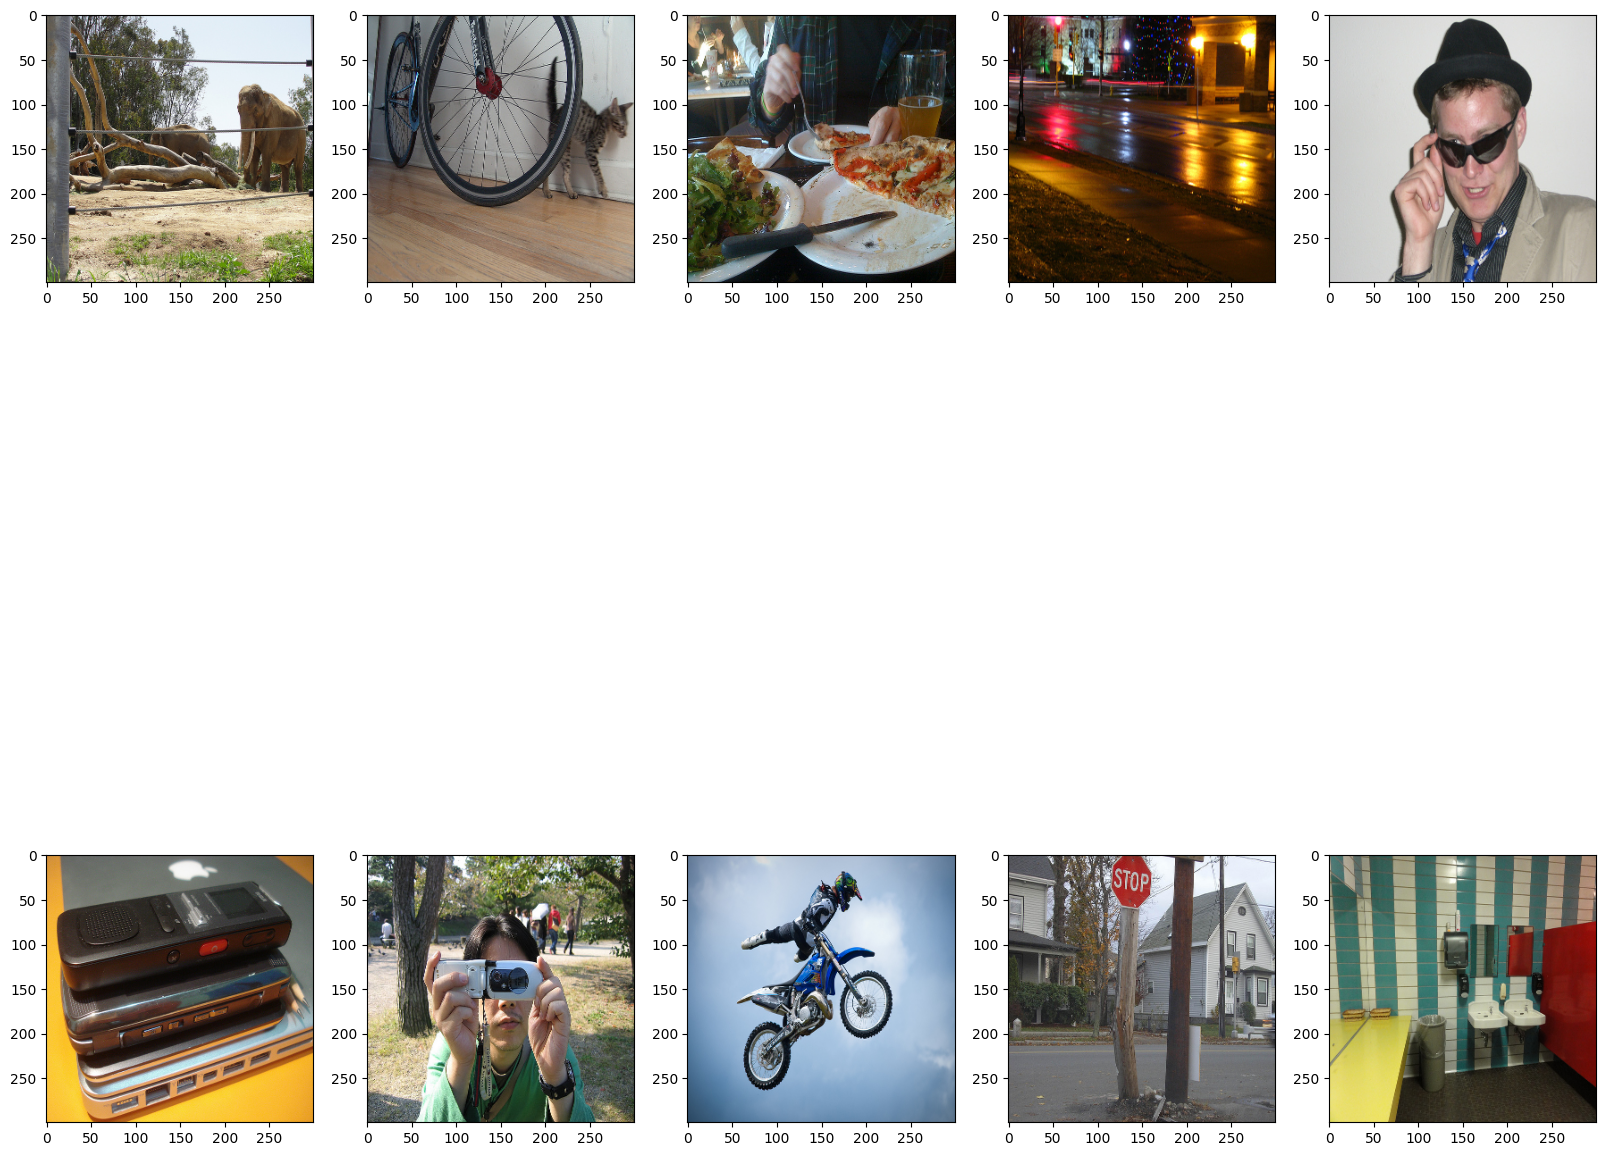

In [6]:
cnt=0 
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,20))
row=0
col=0
for i, ([images_array], labels_array) in enumerate(imageIterator, 0):
    for k in images_array:
        cnt = cnt+1
        image=k.astype("int")
        axes[row,col].imshow(image)
        row=row+1
        if(row==2):
            row=0
            if(col!=4):
                col =col+1
imageIterator.reset()